### Import Required libraries

In [31]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

warnings.filterwarnings('ignore')

### 3.1 Data Preprocessing

In [3]:
# Load the data
energy_data = pd.read_csv("data/energydata_complete.csv")

# format dates
energy_data['date'] = pd.to_datetime(energy_data['date'], format="%Y-%m-%d %H:%M:%S")

In [19]:
energy_data

date  Appliances  lights         T1       RH_1  \
0     2016-01-11 17:00:00          60      30  19.890000  47.596667   
1     2016-01-11 17:10:00          60      30  19.890000  46.693333   
2     2016-01-11 17:20:00          50      30  19.890000  46.300000   
3     2016-01-11 17:30:00          50      40  19.890000  46.066667   
4     2016-01-11 17:40:00          60      40  19.890000  46.333333   
...                   ...         ...     ...        ...        ...   
19730 2016-05-27 17:20:00         100       0  25.566667  46.560000   
19731 2016-05-27 17:30:00          90       0  25.500000  46.500000   
19732 2016-05-27 17:40:00         270      10  25.500000  46.596667   
19733 2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734 2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...  \
0      19.200000  44.790000  19.790000  44.730000  19.000000  ...   
1      19.200000  44.722500  19.790000  44.790000  19.000000  ...   
2      19.200000  44.626667  19.790000  44.933333  18.926667  ...   
3      19.200000  44.590000  19.790000  45.000000  18.890000  ...   
4      19.200000  44.530000  19.790000  45.000000  18.890000  ...   
...          ...        ...        ...        ...        ...  ...   
19730  25.890000  42.025714  27.200000  41.163333  24.700000  ...   
19731  25.754000  42.080000  27.133333  41.223333  24.700000  ...   
19732  25.628571  42.768571  27.050000  41.690000  24.700000  ...   
19733  25.414000  43.036000  26.890000  41.290000  24.700000  ...   
19734  25.264286  42.971429  26.823333  41.156667  24.700000  ...   

       Day_of_week  Hour  Month  Day  Season  Hour_sin      Hour_cos       my  \
0           Monday    17      1   11  Winter -0.965926 -2.588190e-01  2016-01   
1           Monday    17      1   11  Winter -0.965926 -2.588190e-01  2016-01   
2           Monday    17      1   11  Winter -0.965926 -2.588190e-01  2016-01   
3           Monday    17      1   11  Winter -0.965926 -2.588190e-01  2016-01   
4           Monday    17      1   11  Winter -0.965926 -2.588190e-01  2016-01   
...            ...   ...    ...  ...     ...       ...           ...      ...   
19730       Friday    17      5   27  Spring -0.965926 -2.588190e-01  2016-05   
19731       Friday    17      5   27  Spring -0.965926 -2.588190e-01  2016-05   
19732       Friday    17      5   27  Spring -0.965926 -2.588190e-01  2016-05   
19733       Friday    17      5   27  Spring -0.965926 -2.588190e-01  2016-05   
19734       Friday    18      5   27  Spring -1.000000 -1.836970e-16  2016-05   

                    mhr  week_year  
0      2016-01-11 17:00          2  
1      2016-01-11 17:00          2  
2      2016-01-11 17:00          2  
3      2016-01-11 17:00          2  
4      2016-01-11 17:00          2  
...                 ...        ...  
19730  2016-05-27 17:00         21  
19731  2016-05-27 17:00         21  
19732  2016-05-27 17:00         21  
19733  2016-05-27 17:00         21  
19734  2016-05-27 18:00         21  

[19735 rows x 41 columns]

#### 3.1.1 Feature Engineering

In [4]:
# Feature engineering
def second_day(x):
    return x.hour * 3600 + x.minute * 60 + x.second

def weekend_weekday(x):
    if x.weekday() >= 5:
        return 'Weekend'
    else:
        return 'Weekday'

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# Existing feature engineering
energy_data['NSM'] = energy_data['date'].apply(second_day)
energy_data['WeekStatus'] = energy_data['date'].apply(weekend_weekday)
energy_data['Day_of_week'] = energy_data['date'].dt.day_name()

# Additional feature engineering
energy_data['Hour'] = energy_data['date'].dt.hour
energy_data['Month'] = energy_data['date'].dt.month
energy_data['Day'] = energy_data['date'].dt.day

# Create seasonal categorical data
energy_data['Season'] = energy_data['Month'].apply(get_season)

# Cyclical encoding for hour
energy_data['Hour_sin'] = np.sin(2 * np.pi * energy_data['Hour'] / 24)
energy_data['Hour_cos'] = np.cos(2 * np.pi * energy_data['Hour'] / 24)

#### 3.1.2 Convertion

In [5]:
# Convert to categorical
energy_data['Day_of_week'] = energy_data['Day_of_week'].astype('category')
energy_data['WeekStatus'] = energy_data['WeekStatus'].astype('category')
energy_data['Season'] = energy_data['Season'].astype('category')

# Check feature engineering
energy_data.sample(4)

date  Appliances  lights     T1       RH_1     T2   RH_2  \
7554  2016-03-04 04:00:00          50       0  21.29  36.090000  19.29  37.40   
6574  2016-02-26 08:40:00          70       0  20.10  39.592500  18.20  40.40   
4348  2016-02-10 21:40:00         110      20  21.39  43.326667  21.20  41.29   
15766 2016-04-30 04:40:00          50       0  21.65  37.145000  18.89  40.09   

          T3   RH_3         T4  ...        rv2    NSM  WeekStatus  \
7554   20.89  38.29  19.514286  ...  47.100907  14400     Weekday   
6574   20.89  38.00  19.890000  ...  20.245405  31200     Weekday   
4348   21.00  42.20  19.200000  ...   4.297590  78000     Weekday   
15766  22.89  37.20  19.390000  ...  24.737340  16800     Weekend   

       Day_of_week  Hour  Month  Day  Season  Hour_sin  Hour_cos  
7554        Friday     4      3    4  Spring  0.866025  0.500000  
6574        Friday     8      2   26  Winter  0.866025 -0.500000  
4348     Wednesday    21      2   10  Winter -0.707107  0.707107  
15766     Saturday     4      4   30  Spring  0.866025  0.500000  

[4 rows x 38 columns]

#### 3.1.3 Visualization

In [6]:
energy_data.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM', 'WeekStatus',
       'Day_of_week', 'Hour', 'Month', 'Day', 'Season', 'Hour_sin',
       'Hour_cos'],
      dtype='object')

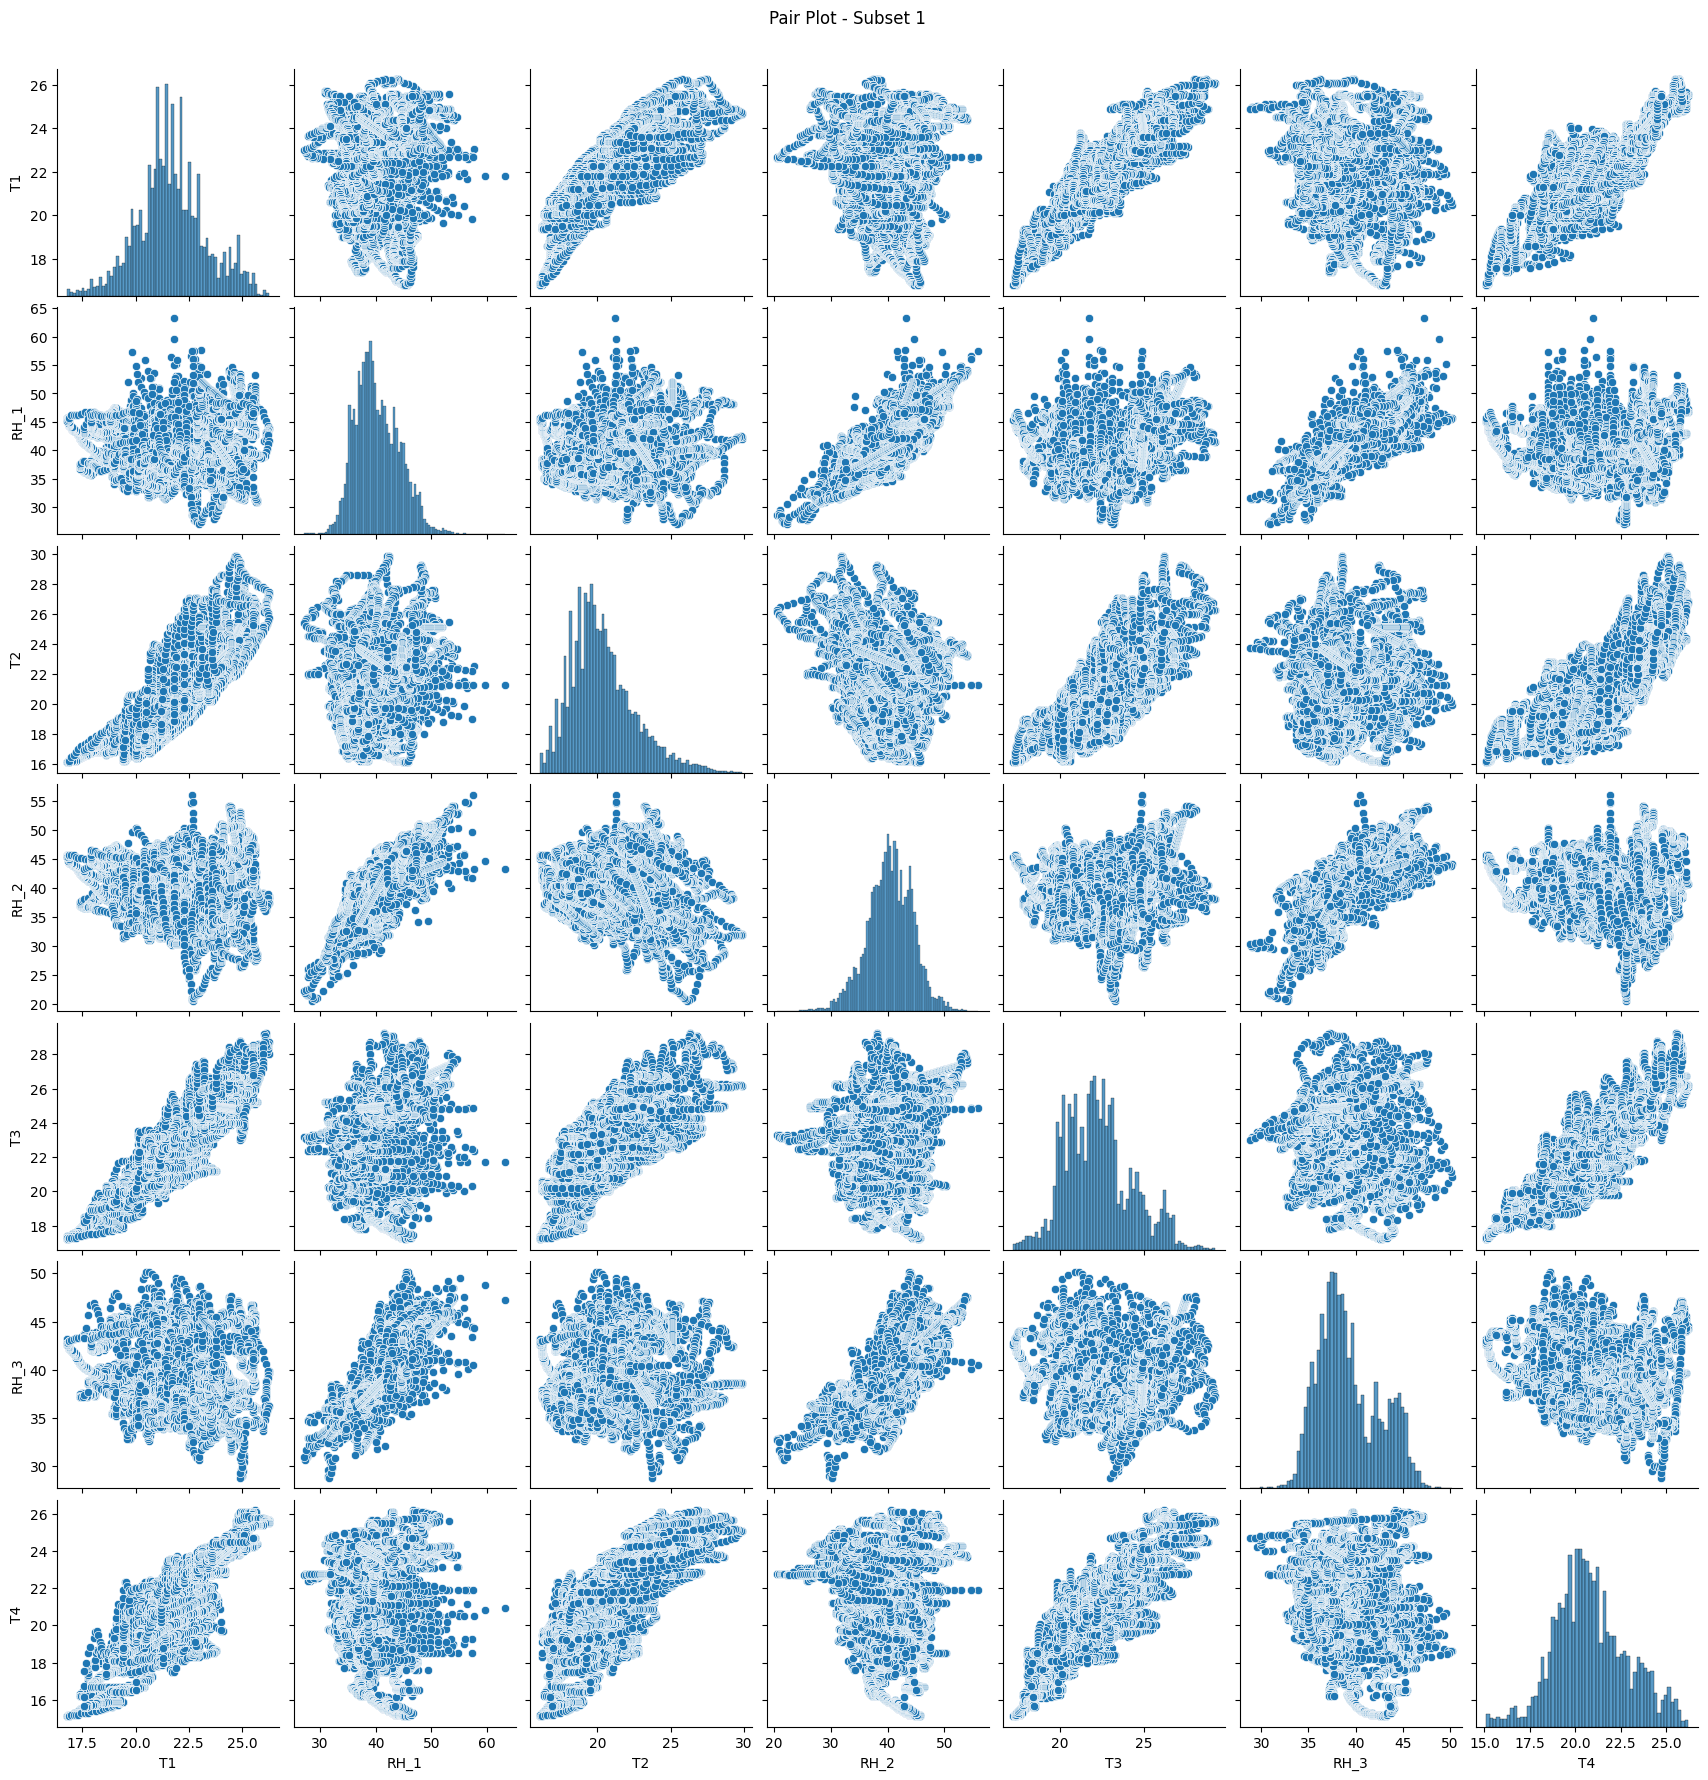

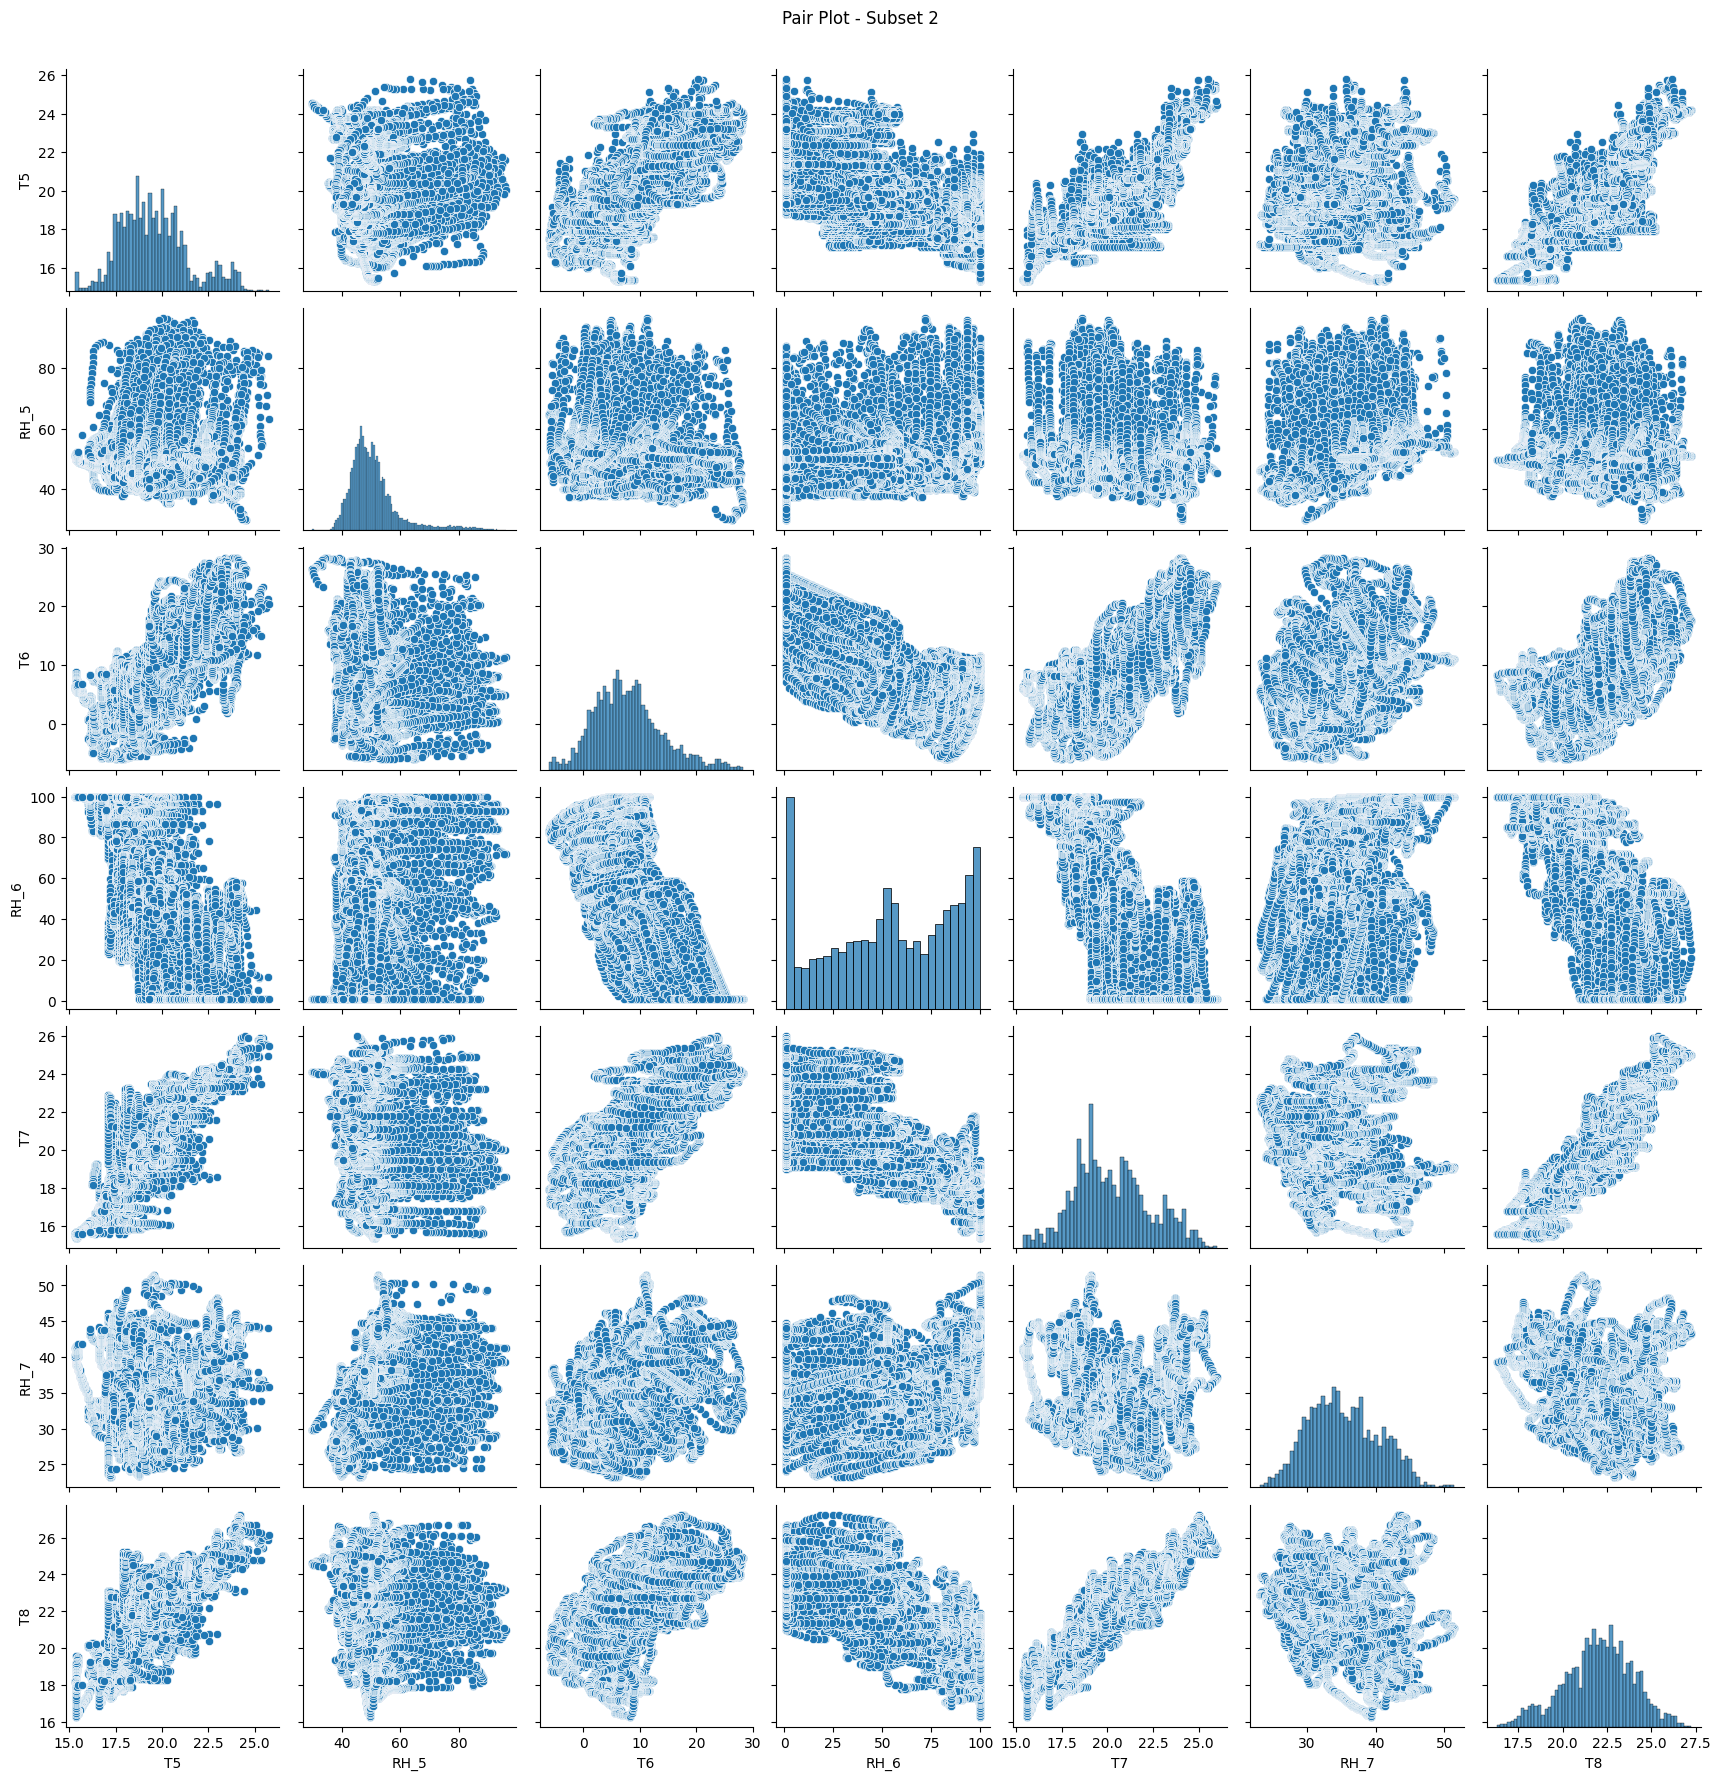

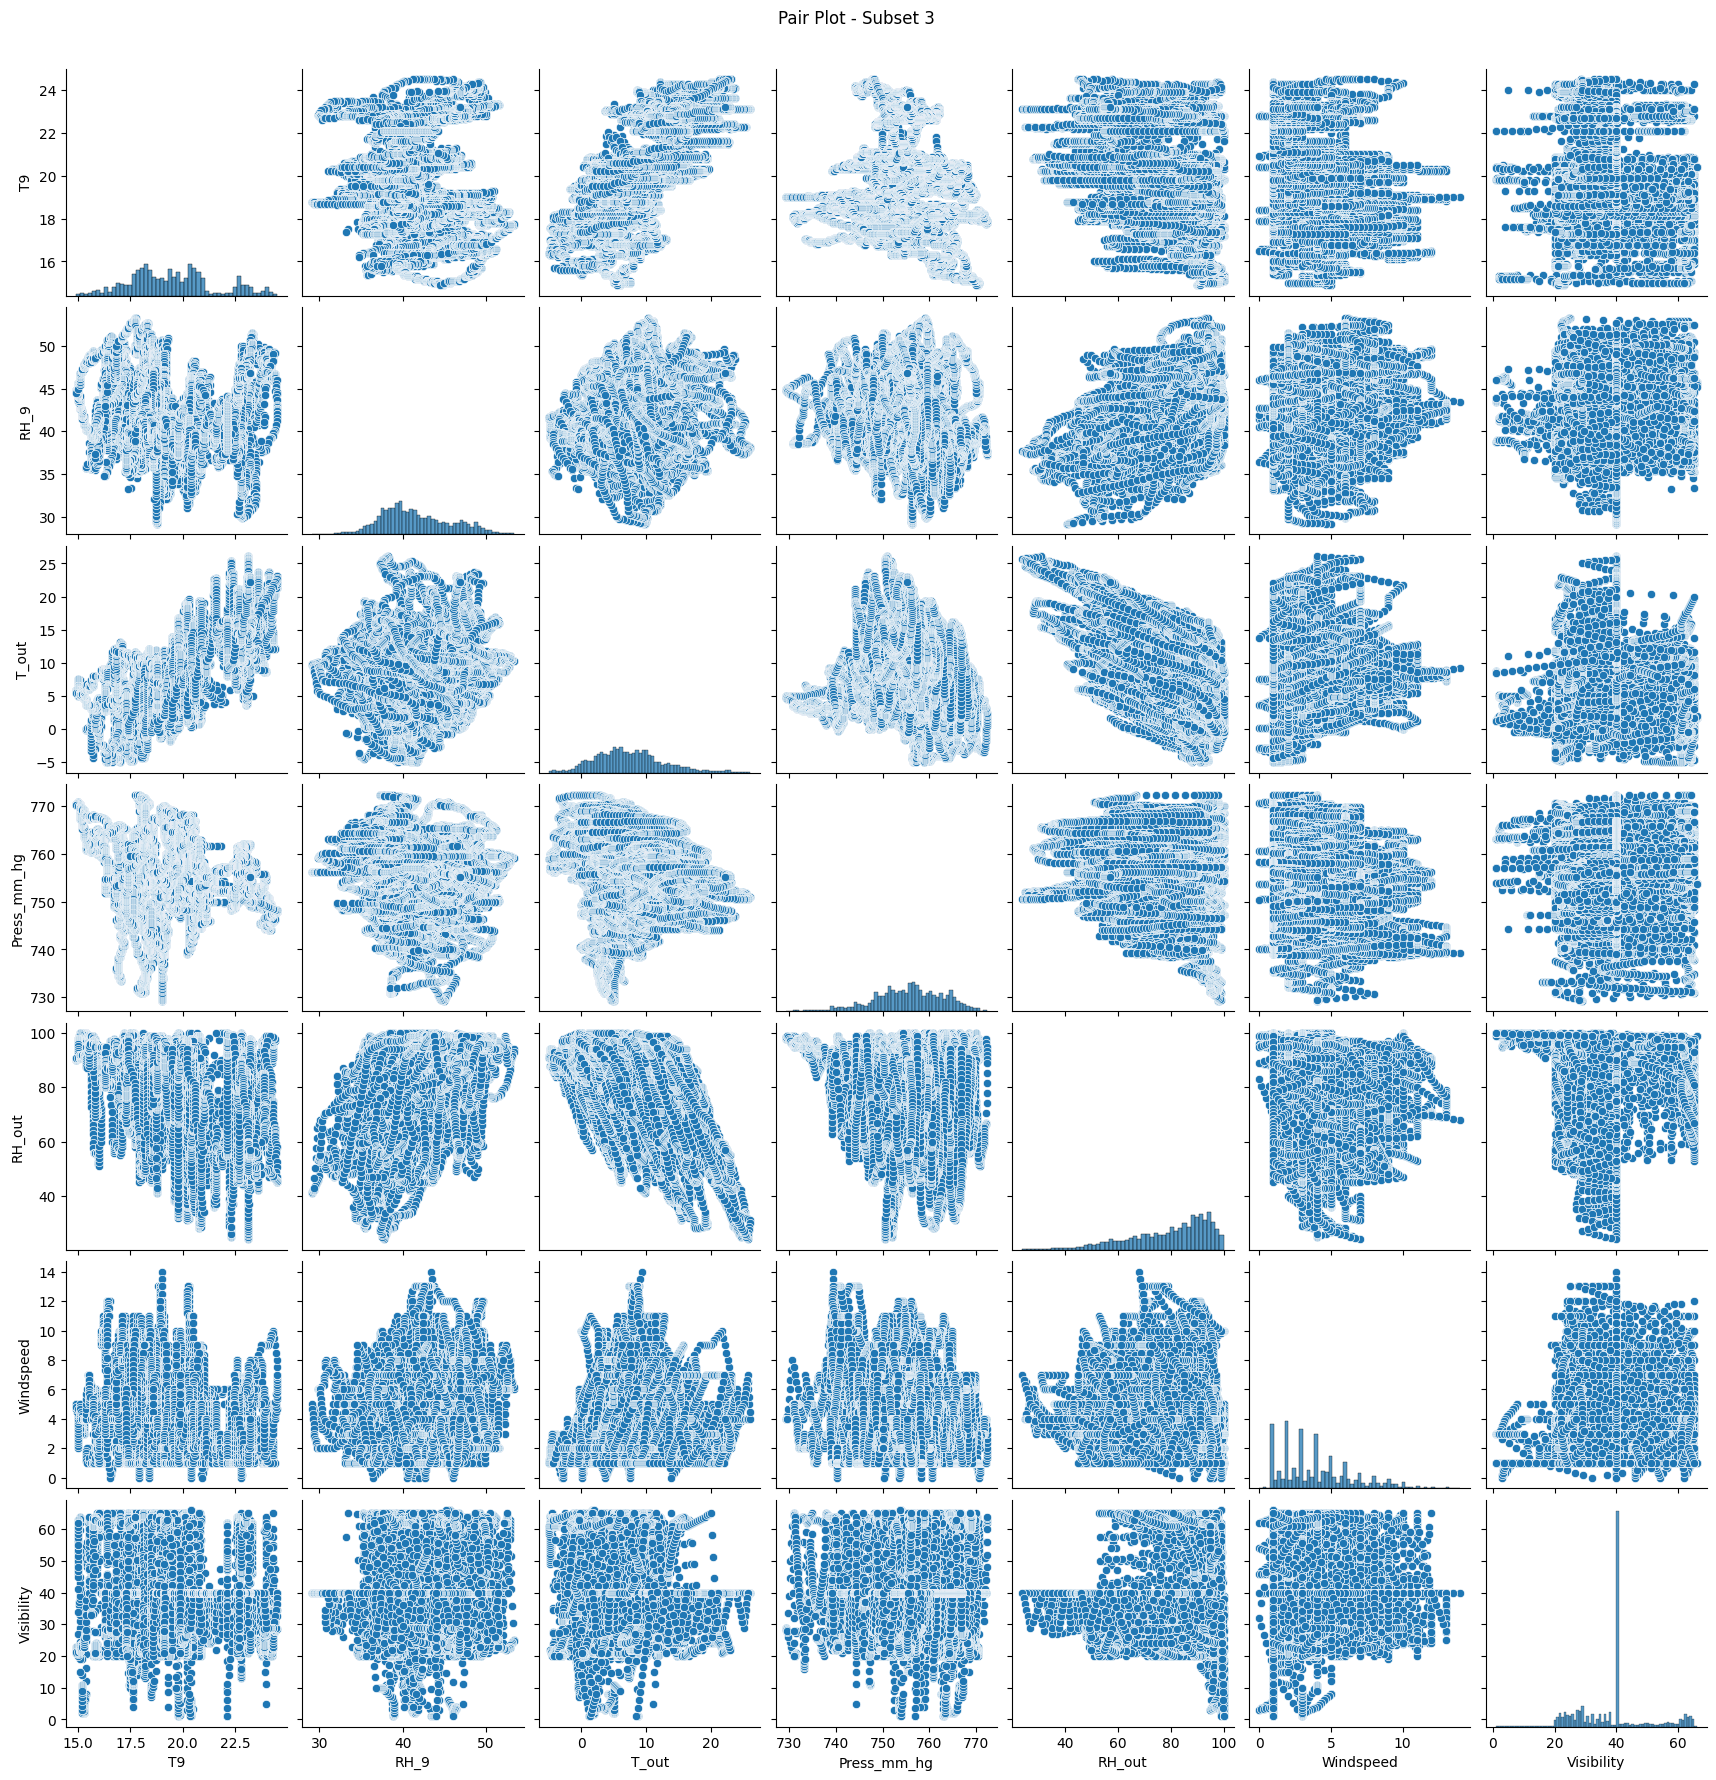

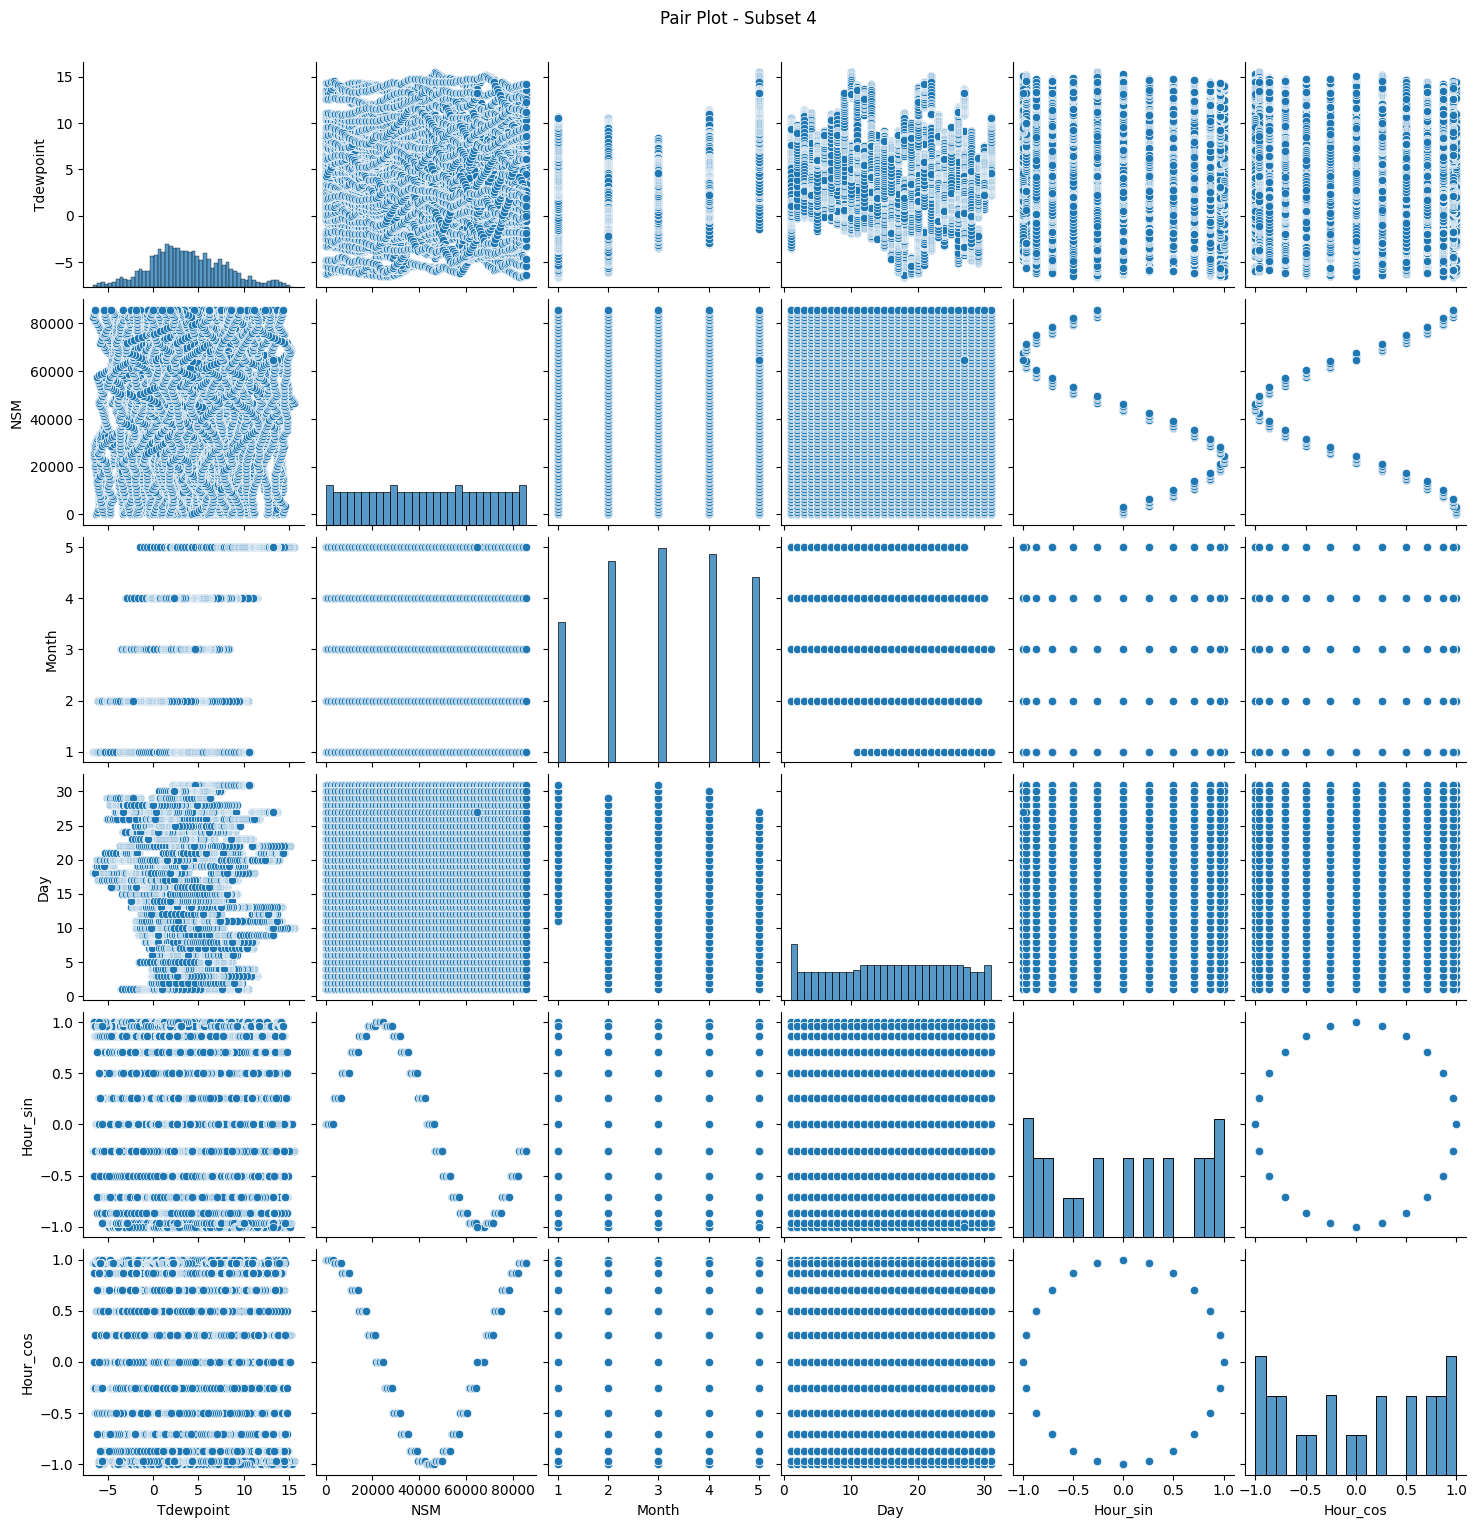

In [8]:
# Select columns for the pair plot
columns_subset_1 = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4']  # First subset of columns
columns_subset_2 = ['T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8']  # Second subset of columns
columns_subset_3 = ['T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility']  # Third subset of columns
columns_subset_4 = ['Tdewpoint', 'NSM', 'WeekStatus', 'Day_of_week', 'Month', 'Day', 'Season', 'Hour_sin', 'Hour_cos']  # Fourth subset of columns

# Pair plot for the first subset
sns.pairplot(energy_data[columns_subset_1])
plt.suptitle('Pair Plot - Subset 1', y=1.02)
plt.savefig('Image/pairplot 1.png')
plt.show()

# Pair plot for the second subset
sns.pairplot(energy_data[columns_subset_2])
plt.suptitle('Pair Plot - Subset 2', y=1.02)
plt.savefig('Image/pairplot 2.png')
plt.show()

# Pair plot for the third subset
sns.pairplot(energy_data[columns_subset_3])
plt.suptitle('Pair Plot - Subset 3', y=1.02)
plt.savefig('Image/pairplot 3.png')
plt.show()

# Pair plot for the fourth subset
sns.pairplot(energy_data[columns_subset_4])
plt.suptitle('Pair Plot - Subset 4', y=1.02)
plt.savefig('Image/pairplot 4.png')
plt.show()

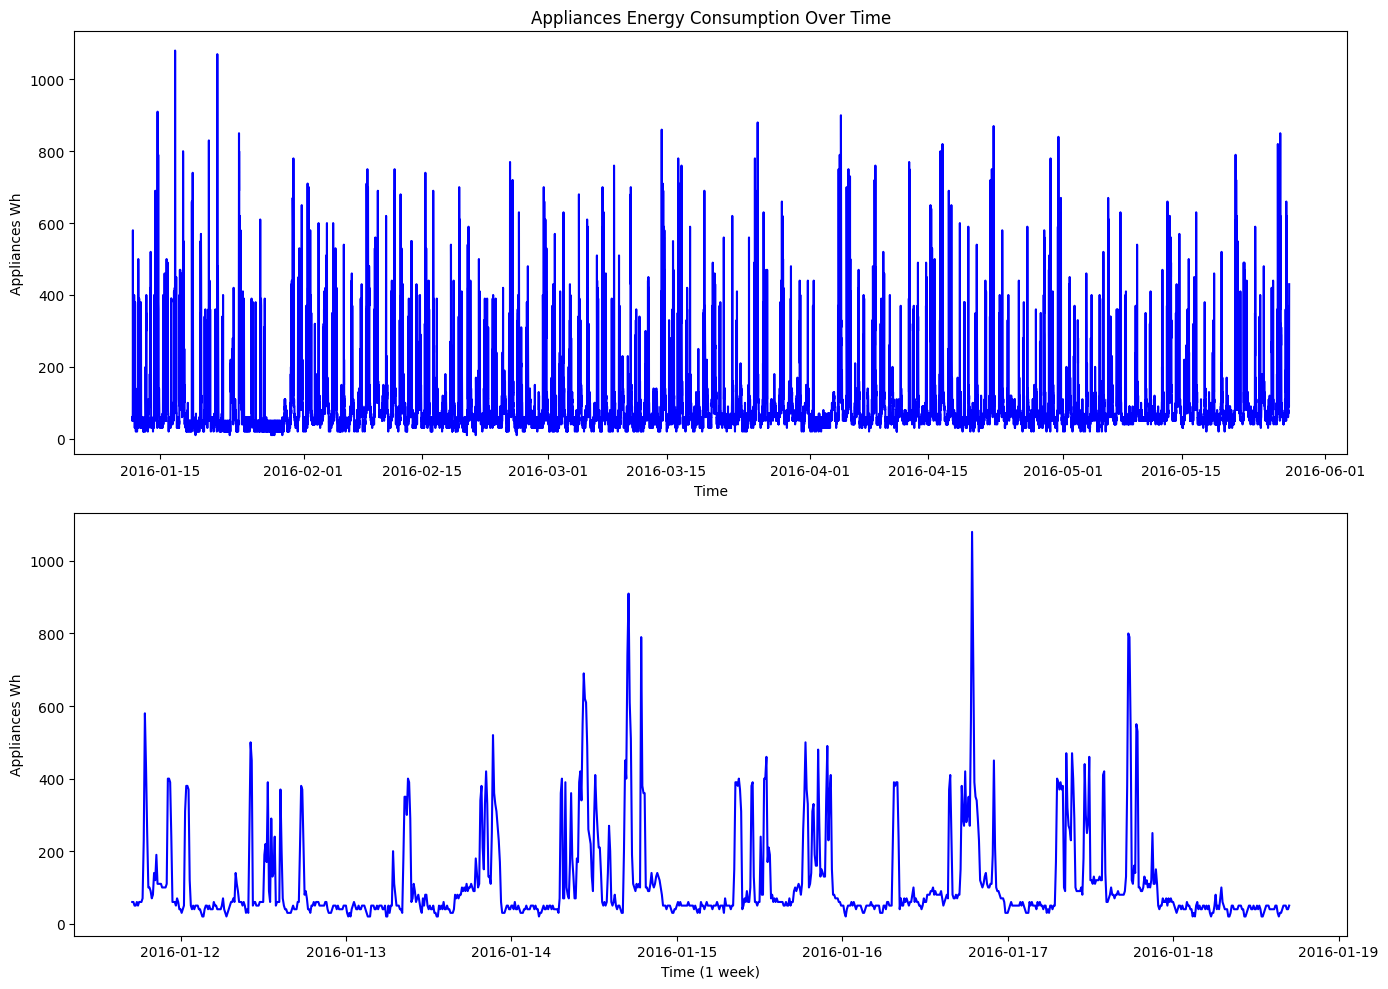

In [9]:
#  Plotting trend in Appliance energy consumption
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(energy_data['date'], energy_data['Appliances'], color='blue')
plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.title('Appliances Energy Consumption Over Time')

plt.subplot(2, 1, 2)
plt.plot(energy_data['date'][:1008], energy_data['Appliances'][:1008], color='blue')
plt.xlabel('Time (1 week)')
plt.ylabel('Appliances Wh')

plt.tight_layout()
plt.savefig('Image/Appliances_profile_3_Jan29.png', dpi=300)
plt.show()

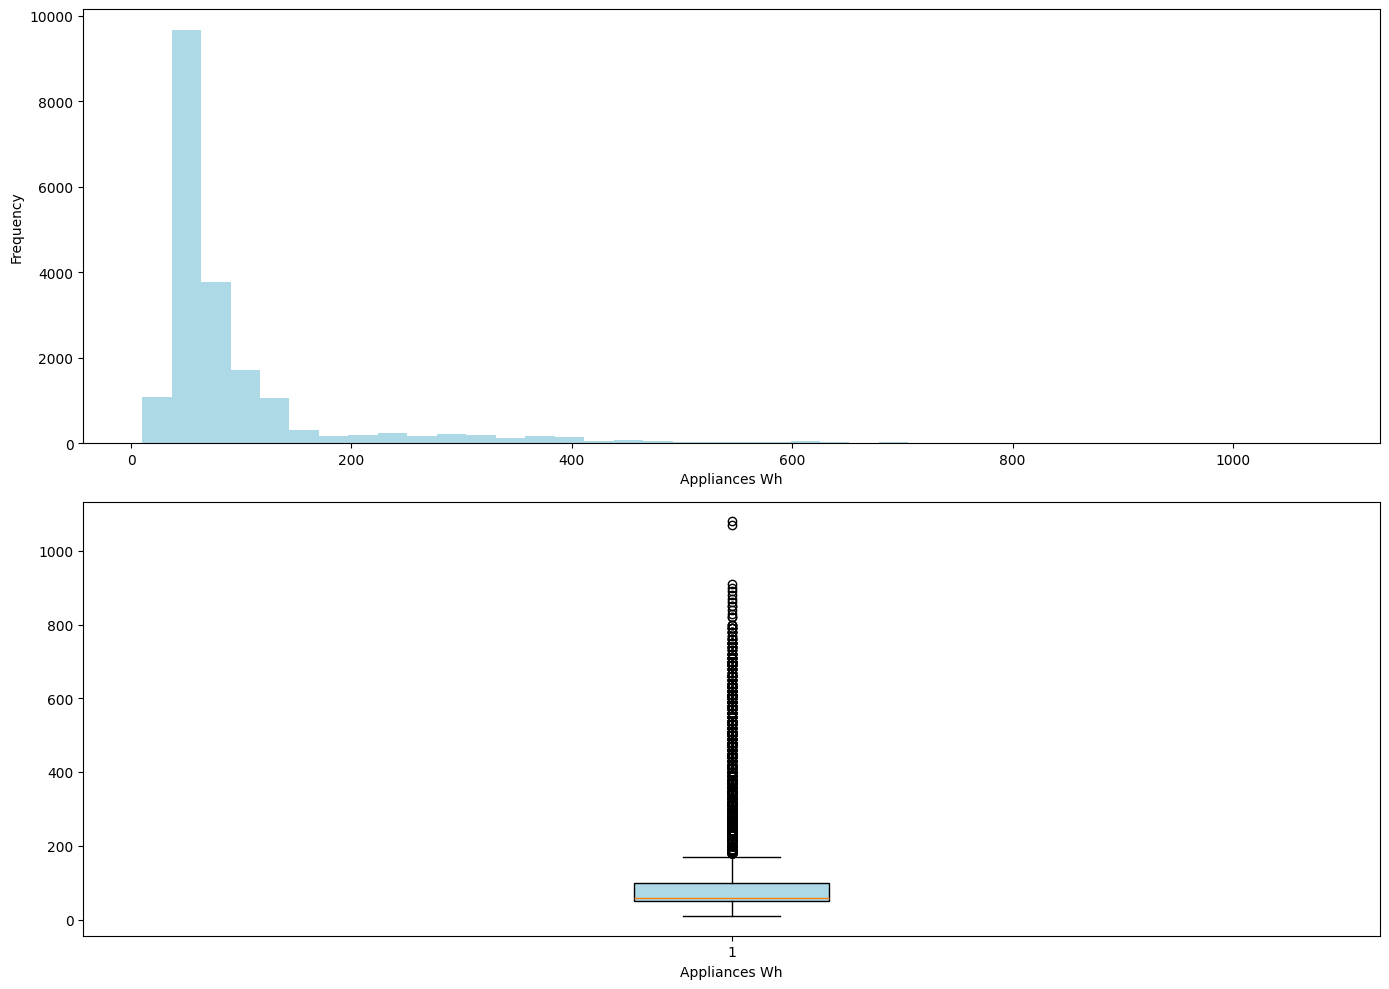

In [10]:
# Histogram of Appliance energy consumption
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.hist(energy_data['Appliances'], bins=40, color='lightblue')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
plt.boxplot(energy_data['Appliances'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel('Appliances Wh')

plt.tight_layout()
plt.savefig('Image/Appliances_histogram_boxplot2_Jan29.png', dpi=300)
plt.show()

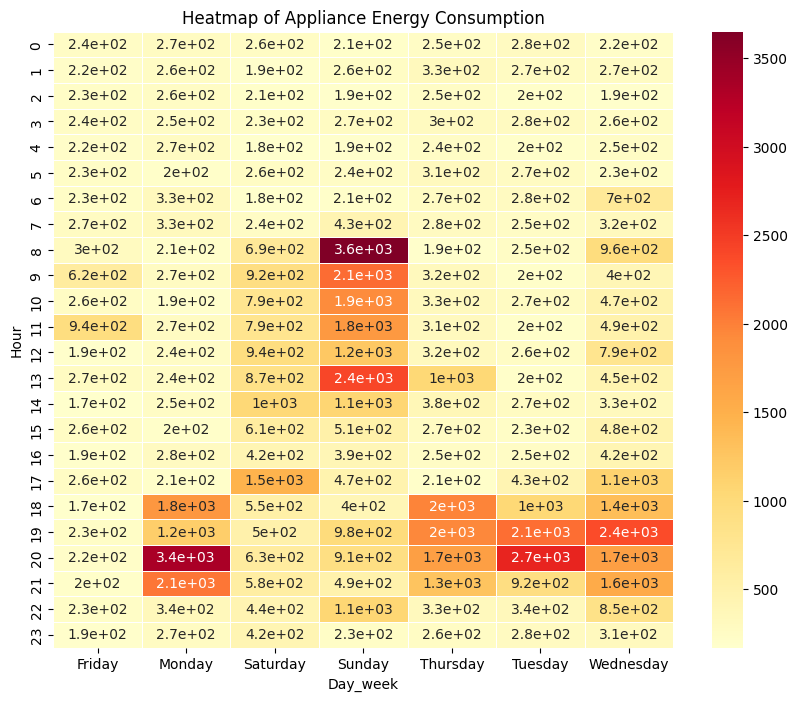

In [ ]:
import calendar

# Create new time variables
energy_data['my'] = energy_data['date'].dt.to_period('M')
energy_data['mhr'] = energy_data['date'].dt.to_period('H')

hourly_data = energy_data.groupby('mhr').agg({'Appliances': 'sum'}).reset_index()
hourly_data['Day_week'] = hourly_data['mhr'].dt.dayofweek
hourly_data['Hour'] = hourly_data['mhr'].dt.hour

# Convert the 'mhr' period to a timestamp and then extract the week number
hourly_data['week_year'] = hourly_data['mhr'].dt.start_time.dt.isocalendar().week

# Map the day of the week to actual names
hourly_data['Day_week'] = hourly_data['Day_week'].map({i: day for i, day in enumerate(calendar.day_name)})

# Filter for the specific week
weekly_data = hourly_data[hourly_data['week_year'] == 3]

# Create the heatmap
plt.figure(figsize=(10, 8))
pivot = weekly_data.pivot_table(values='Appliances', index='Hour', columns='Day_week', aggfunc='sum')
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5, annot=False)
plt.title('Heatmap of Appliance Energy Consumption')
plt.savefig('Image/heatmap_Jan29.png', dpi=300)
plt.show()


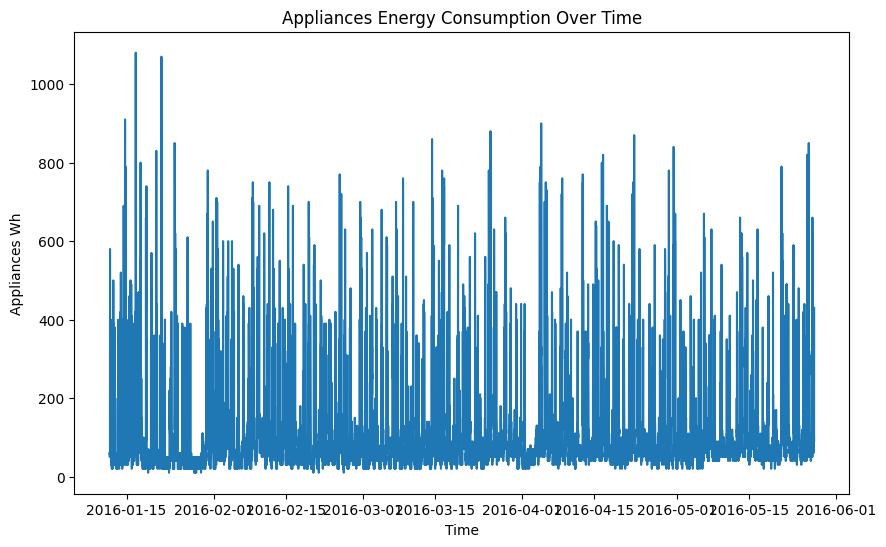

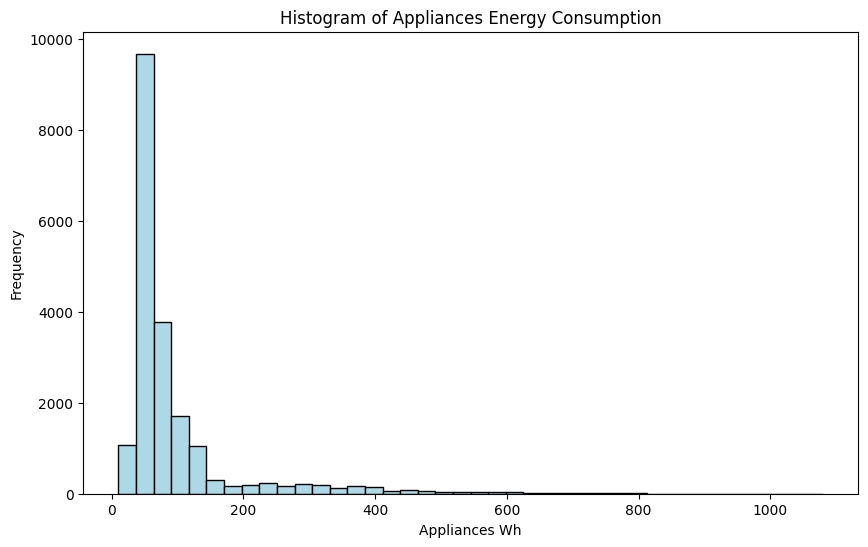

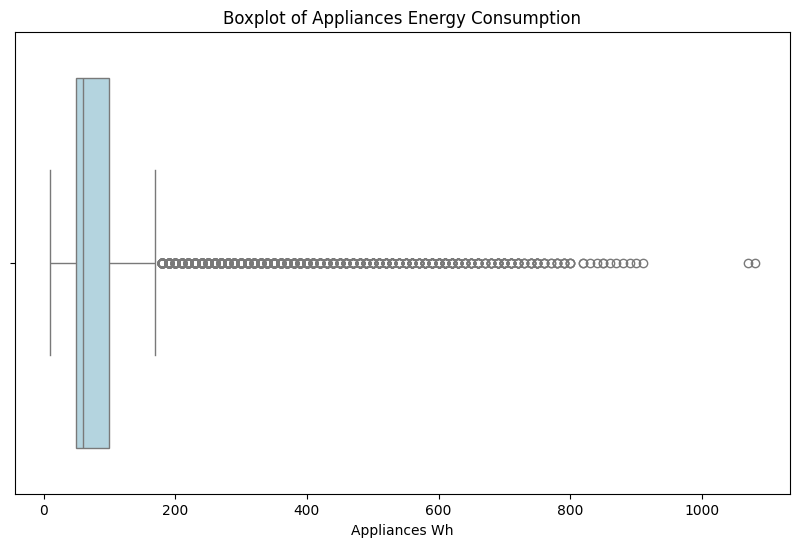

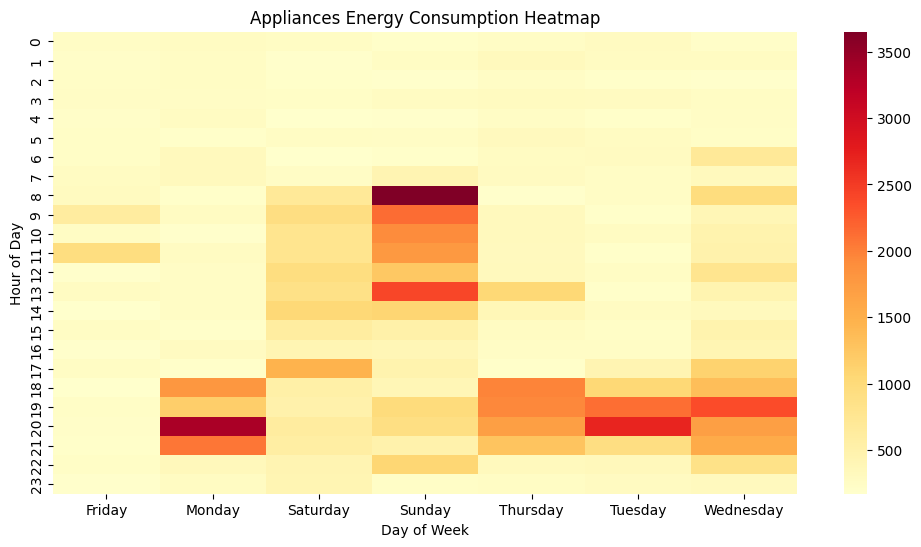

In [15]:
# Appliances profile plot
plt.figure(figsize=(10, 6))
plt.plot(energy_data['date'], energy_data['Appliances'], label='Appliances')
plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.title('Appliances Energy Consumption Over Time')
plt.savefig('Image/Appliances Energy Consumption Over Time.png', dpi=300)

plt.show()

# Boxplot and Histogram
plt.figure(figsize=(10, 6))
plt.hist(energy_data['Appliances'], bins=40, color='lightblue', edgecolor='black')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')
plt.title('Histogram of Appliances Energy Consumption')
plt.savefig('Image/Histogram of Appliances Energy Consumption.png', dpi=300)

plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=energy_data, x='Appliances', color='lightblue')
plt.xlabel('Appliances Wh')
plt.title('Boxplot of Appliances Energy Consumption')
plt.savefig('Image/Boxplot of Appliances Energy Consumption.png', dpi=300)
plt.show()

# Heat map visualization for a specific week
energy_data['Hour'] = energy_data['date'].dt.hour
energy_data['week_year'] = energy_data['date'].dt.isocalendar().week
energy_data_w1 = energy_data[energy_data['week_year'] == 3]

heatmap_data = energy_data_w1.pivot_table(values='Appliances', index='Hour', columns='Day_of_week', aggfunc=np.sum)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('Appliances Energy Consumption Heatmap')
plt.savefig('Image/Appliances Energy Consumption Heatmap.png', dpi=300)
plt.show()

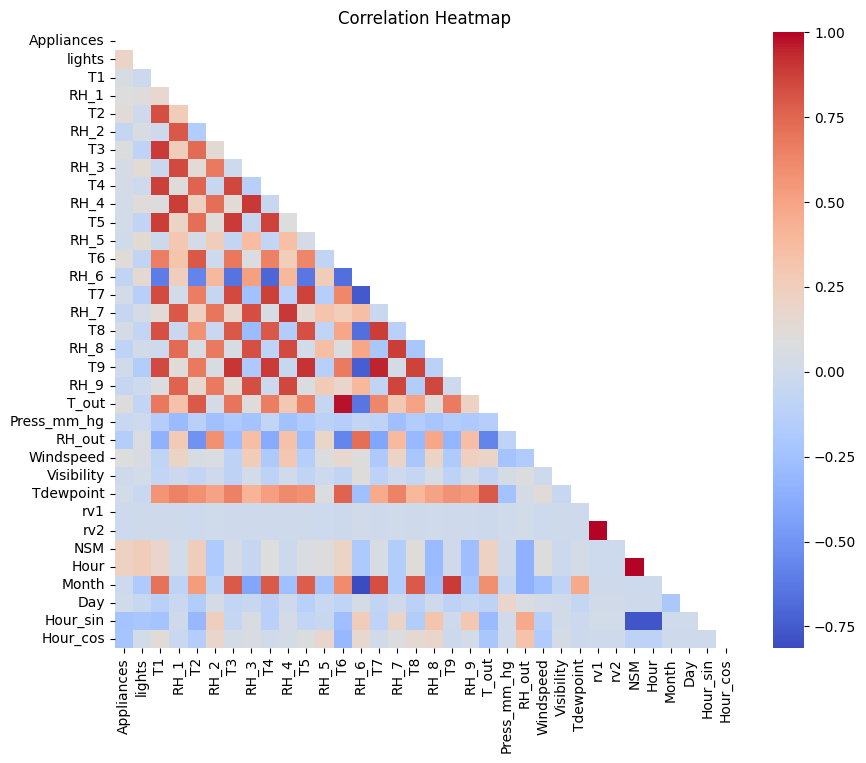

In [13]:
# Correlation heatmap of numeric columns
corr = energy_data.select_dtypes(['int', 'float']).corr()
matrix = np.triu(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', mask=matrix)
plt.title('Correlation Heatmap')
plt.savefig('Image/Correlation Heatmap.png', dpi=300)
plt.show()

# Modelling

In [16]:
# Drop unrequired columns
data = energy_data.drop(columns=['my', 'mhr', 'date', 'week_year'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Appliances   19735 non-null  int64   
 1   lights       19735 non-null  int64   
 2   T1           19735 non-null  float64 
 3   RH_1         19735 non-null  float64 
 4   T2           19735 non-null  float64 
 5   RH_2         19735 non-null  float64 
 6   T3           19735 non-null  float64 
 7   RH_3         19735 non-null  float64 
 8   T4           19735 non-null  float64 
 9   RH_4         19735 non-null  float64 
 10  T5           19735 non-null  float64 
 11  RH_5         19735 non-null  float64 
 12  T6           19735 non-null  float64 
 13  RH_6         19735 non-null  float64 
 14  T7           19735 non-null  float64 
 15  RH_7         19735 non-null  float64 
 16  T8           19735 non-null  float64 
 17  RH_8         19735 non-null  float64 
 18  T9           19735 non-nul

In [18]:
data.head()

Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   
3          50      40  19.89  46.066667  19.2  44.590000  19.79  45.000000   
4          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000   

          T4       RH_4  ...        rv2    NSM  WeekStatus  Day_of_week  Hour  \
0  19.000000  45.566667  ...  13.275433  61200     Weekday       Monday    17   
1  19.000000  45.992500  ...  18.606195  61800     Weekday       Monday    17   
2  18.926667  45.890000  ...  28.642668  62400     Weekday       Monday    17   
3  18.890000  45.723333  ...  45.410389  63000     Weekday       Monday    17   
4  18.890000  45.530000  ...  10.084097  63600     Weekday       Monday    17   

   Month  Day  Season  Hour_sin  Hour_cos  
0      1   11  Winter -0.965926 -0.258819  
1      1   11  Winter -0.965926 -0.258819  
2      1   11  Winter -0.965926 -0.258819  
3      1   11  Winter -0.965926 -0.258819  
4      1   11  Winter -0.965926 -0.258819  

[5 rows x 37 columns]

### Preprocessing

In [46]:
# Split data into training and testing sets
train_data, val_test_data = train_test_split(data, test_size=0.4, random_state=42)

# Split test data into test and val .5
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)
    
categorical_cols = data.select_dtypes('category').columns.to_list()
categorical_cols

['WeekStatus', 'Day_of_week', 'Season']

In [ ]:
# Encode categorical columns
train = pd.get_dummies(train_data, columns=categorical_cols)
val = pd.get_dummies(val_data, columns=categorical_cols)
test = pd.get_dummies(test_data, columns=categorical_cols)

train[train.select_dtypes('bool').columns] = train.select_dtypes('bool').astype(int)
val[val.select_dtypes('bool').columns] = val.select_dtypes('bool').astype(int)
test[test.select_dtypes('bool').columns] = test.select_dtypes('bool').astype(int)

In [23]:
# Model training
features = [col for col in train.columns if col not in ['Appliances']]

# Models Training

In [50]:
# Splitting training set 
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features]) # Standardize X Values
y_train = train['Appliances']

pd.DataFrame(X_train, columns=features).to_csv('new_data/X_train.csv', index=False)
y_train.to_csv('new_data/y_train.csv', index=False)

# Splitting validation set 
X_val = scaler.transform(val[features]) # Standardize X Values
y_val = val['Appliances']

pd.DataFrame(X_val, columns=features).to_csv('new_data/X_val.csv', index=False)
y_val.to_csv('new_data/y_val.csv', index=False)

# Splitting testing set 
X_test = scaler.transform(test[features]) # Standardize X Values
y_test = test['Appliances']

pd.DataFrame(X_test, columns=features).to_csv('new_data/X_test.csv', index=False)
y_test.to_csv('new_data/y_test.csv', index=False)

In [ ]:
# Defining a function to print Metrics
def print_metrics(model_name, grid=None):
    train_pred = model_name.predict(X_train)
    val_pred = model_name.predict(X_val)
    test_pred = model_name.predict(X_test)
    # print('Training Set')
    # print(f'RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
    # print(f'MAE: {mean_absolute_error(y_train, train_pred)}')
    # print(f'MAPE: {mean_absolute_percentage_error(y_train, train_pred)}')
    # print(f'R2: {r2_score(y_train, train_pred)}')

    # print(f'\n\nValidation Set')
    # print(f'RMSE: {np.sqrt(mean_squared_error(y_val, val_pred))}')
    # print(f'MAE: {mean_absolute_error(y_val, val_pred)}')
    # print(f'MAPE: {mean_absolute_percentage_error(y_val, val_pred)}')
    # print(f'R2: {r2_score(y_val, val_pred)}')

    # print(f'\n\nTesting Set')
    # print(f'RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')
    # print(f'MAE: {mean_absolute_error(y_test, test_pred)}')
    # print(f'MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
    # print(f'R2: {r2_score(y_test, test_pred)}')
    
    if grid:
        print(f'\n\nBest Estimator: {grid.best_estimator_}')
        print(f'Best Parameters: {grid.best_params_}')

    all_metrics = {
        'Train_RMSE': float(np.sqrt(mean_squared_error(y_train, train_pred))),
        'Train_MAE': mean_absolute_error(y_train, train_pred),
        'Train_MAPE': mean_absolute_percentage_error(y_train, train_pred),
        'Train_R2': r2_score(y_train, train_pred),
        'Val_RMSE': float(np.sqrt(mean_squared_error(y_val, val_pred))),
        'Val_MAE': mean_absolute_error(y_val, val_pred),
        'Val_MAPE': mean_absolute_percentage_error(y_val, val_pred),
        'Val_R2': r2_score(y_val, val_pred),
        'Test_RMSE': float(np.sqrt(mean_squared_error(y_test, test_pred))),    
        'Test_MAE': mean_absolute_error(y_test, test_pred),
        'Test_MAPE': mean_absolute_percentage_error(y_test, test_pred),
        'Test_R2': r2_score(y_test, test_pred)
    }
    return all_metrics

## 1. Linear Regression

### Training

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Save the tuned model
joblib.dump(lr, 'models/best_lr.pkl')

# Predictions
y_pred_train_slr = lr.predict(X_train)

### Model evaluation and Feature importance 

In [66]:
print_metrics(lr)

{'Train_RMSE': 89.80792843447126,
 'Train_MAE': 50.8808025607048,
 'Train_MAPE': 0.5842879800555462,
 'Train_R2': 0.21872232871136843,
 'Val_RMSE': 90.68537774186544,
 'Val_MAE': 51.77130819550538,
 'Val_MAPE': 0.6064358556061564,
 'Val_R2': 0.18146692763699368,
 'Test_RMSE': 96.47119504645464,
 'Test_MAE': 53.696953584226904,
 'Test_MAPE': 0.5905621500873515,
 'Test_R2': 0.19256738271448803}

## 2. RandomForest Model

### Training

In [28]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predictions
y_pred_train_srf = rf.predict(X_train)

### Hyper-parameter Tuning

In [ ]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5]
}
rf_grid = HalvingRandomSearchCV(rf, rf_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
joblib.dump(best_rf, 'models/best_rf.pkl')

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 6
min_resources_: 20
max_resources_: 11841
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 20
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 1
n_resources: 180
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Training Set
RMSE: 26.176392989099366
MAE: 12.442538636939448
MAPE: 0.12372046566469105
R2: 0.9336263563761753

Testing Set
RMSE: 72.96003263029515
MAE: 34.88180896883709
MAPE: 0.33969752062214087
R2: 0.5066532950840478


Best Estimator: RandomForestRegressor(n_estimators=1000)
Best Parameters: {'n_estimators': 1000, 'max_depth': None}


In [67]:
print_metrics(best_rf, rf_grid)



Best Estimator: RandomForestRegressor(n_estimators=1000)
Best Parameters: {'n_estimators': 1000, 'max_depth': None}


{'Train_RMSE': 26.176392989099366,
 'Train_MAE': 12.442538636939448,
 'Train_MAPE': 0.12372046566469105,
 'Train_R2': 0.9336263563761753,
 'Val_RMSE': 69.47136377474229,
 'Val_MAE': 33.70186724094249,
 'Val_MAPE': 0.3433339902475549,
 'Val_R2': 0.5196327976317487,
 'Test_RMSE': 76.28933305584006,
 'Test_MAE': 36.0617506967317,
 'Test_MAPE': 0.3360610509967269,
 'Test_R2': 0.49506135669101625}

## 3. Logistic Regression

### Training

In [32]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

# Save the tuned model
joblib.dump(logit, 'models/best_logit.pkl')

# Prediction
y_pred_train_logit = logit.predict(X_train)

### Hyper-parameter tuning

In [ ]:
# Hyperparameter tuning for Logit
logit_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # supports both l1 and l2
    'max_iter': [200, 500]
}
logit_grid = HalvingRandomSearchCV(logit, logit_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
logit_grid.fit(X_train, y_train)
best_logit = logit_grid.best_estimator_
joblib.dump(best_logit, 'models/best_logit.pkl')

print_metrics(best_logit, logit_grid)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1760
max_resources_: 11841
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1760
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 2
n_resources: 5280
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 102.38726366512103
MAE: 42.933873828223966
MAPE: 0.2901285914427022
R2: -0.015471941307569681

Testing Set
RMSE: 106.07843754784402
MAE: 45.12414492019255
MAPE: 0.30054774469563666
R2: -0.04288500092546976


Best Estimator: LogisticRegression(C=1, max_iter=200, solver='liblinear')
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 1}


## 4. Decision Tree Regressor


### Training

In [35]:
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train, y_train)

# Predictions
y_pred_train_sdt = dt.predict(X_train)

### Hyperparameter Tuning

In [36]:
dt_param_grid = {
    'max_depth': [10, 20, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['absolute_error', 'squared_error', 'friedman_mse']
}

dt_grid = HalvingRandomSearchCV(dt, dt_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
joblib.dump(best_dt, 'models/best_dt.pkl')

print_metrics(best_dt, dt_grid)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 7
min_resources_: 10
max_resources_: 11841
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 10
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 30
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 90
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 270
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 810
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training Set
RMSE: 60.792072187703276
MAE: 20.915463221011738
MAPE: 0.1694030160550961
R2: 0.6420107798407335

Testing Set
RMSE: 89.55160236246658
MAE: 39.821383329110716
MAPE: 0.35871865986070983
R2: 0.25676027306795635


Best Estimator: DecisionTreeRegressor(criterion='absolute_error

## 5. Gradient Boosting

### Training

In [37]:
# Gradient Boosting Regressor
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Predictions
y_pred_train_sgbm = gbm.predict(X_train)

### Hyperparameter Tuning

In [38]:
# Hyperparameter tuning for Gradient Boosting
gbm_param_grid = {
    'n_estimators': [200, 500, 1000, 10000],
    'max_depth': [2, 5, 8]
}
gbm_grid = HalvingRandomSearchCV(gbm, gbm_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
gbm_grid.fit(X_train, y_train)
best_gbm = gbm_grid.best_estimator_
joblib.dump(best_gbm, 'models/best_gbm.pkl')

print_metrics(best_gbm, gbm_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 6
min_resources_: 20
max_resources_: 11841
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 22.114537790422027
MAE: 14.058338793747275
MAPE: 0.1821682740809856
R2: 0.952626901818394

Testing Set
RMSE: 72.7936023540243
MAE: 35.12100810711889
MAPE: 0.3458899400024092
R2: 0.5089014897931599


Best Estimator: GradientBoostingRegressor(max_depth=8, n_estimators=200, random_state=42)
Best Parameters: {'n_estimators': 200, 'max_depth': 8}


## 6. Extra Trees Regressor

### Training

In [39]:
# Training Extra Trees Regressor
et = ExtraTreesRegressor(random_state=1)
et.fit(X_train, y_train)

# Predictions
y_pred_train_set = et.predict(X_train)

### Hyperparameter Tuning for Extra Trees

In [40]:
et_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
et_grid = HalvingRandomSearchCV(et, et_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
et_grid.fit(X_train, y_train)
best_et = et_grid.best_estimator_
joblib.dump(best_et, 'models/best_et.pkl')

print_metrics(best_et, et_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 6
min_resources_: 20
max_resources_: 11841
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 6.030566649805473
MAE: 3.0360803277178046
MAPE: 0.03949365925331592
R2: 0.9964771650350908

Testing Set
RMSE: 69.2372739944067
MAE: 32.07204193822065
MAPE: 0.30837406679031026
R2: 0.5557145263156443


Best Estimator: ExtraTreesRegressor(max_depth=20, n_estimators=200, random_state=1)
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}


## 7. XGBOOST

### Training

In [41]:
# Training XGB Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Predictions
y_pred_train_sxgb = xgb.predict(X_train)

### Hyperparameter Tuning for XG Boost

In [42]:
# Parameter grid for XGBoost (XGB)
xgb_param_grid = {
    'n_estimators': [200, 400, 500],
    'max_depth': [4, 6, 7, 8, 5],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0, 2, 5]
}
xgb_grid = HalvingRandomSearchCV(xgb, xgb_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
joblib.dump(best_xgb, 'models/best_xgb.pkl')

print_metrics(best_xgb, xgb_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 6
min_resources_: 20
max_resources_: 11841
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15
n_resources: 20
Fitting 10 folds for each of 15 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 5
n_resources: 60
Fitting 10 folds for each of 5 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 45.150130694803224
MAE: 25.59272003173828
MAPE: 0.2959994375705719
R2: 0.8025332093238831

Testing Set
RMSE: 76.61279279292232
MAE: 39.47211456298828
MAPE: 0.40477249026298523
R2: 0.45601773262023926


Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
  

# Models Comparison

### Creating a DataFrame of metrics

In [69]:
models = {
    'LM': lr,
    'Logit': best_logit,
    'GBM': best_gbm,
    'RF': best_rf,
    'XGB': best_xgb,
    'ET': best_et,
    'DT': best_dt,
}

grids = {
    'LM': None,
    'Logit': logit_grid,
    'GBM': gbm_grid,
    'RF': rf_grid,
    'XGB': xgb_grid,
    'ET': et_grid,
    'DT': dt_grid,
}

all_results = {}

for name, model in models.items():
    grid_obj = grids.get(name)
    all_results[name] = print_metrics(model, grid=grid_obj)



Best Estimator: LogisticRegression(C=1, max_iter=200, solver='liblinear')
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 1}


Best Estimator: GradientBoostingRegressor(max_depth=8, n_estimators=200, random_state=42)
Best Parameters: {'n_estimators': 200, 'max_depth': 8}


Best Estimator: RandomForestRegressor(n_estimators=1000)
Best Parameters: {'n_estimators': 1000, 'max_depth': None}


Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
            

In [76]:
# Best Model is Extra Trees Regressor based on all set performances

metrics_df = pd.DataFrame(all_results)
metrics_df.to_csv('new_data/model_performance_metrics.csv', index=True)
metrics_df

LM       Logit        GBM         RF        XGB         ET  \
Train_RMSE  89.807928  102.387264  22.114538  26.176393  45.150131   6.030567   
Train_MAE   50.880803   42.933874  14.058339  12.442539  25.592720   3.036080   
Train_MAPE   0.584288    0.290129   0.182168   0.123720   0.295999   0.039494   
Train_R2     0.218722   -0.015472   0.952627   0.933626   0.802533   0.996477   
Val_RMSE    90.685378  101.769249  70.252728  69.471364  72.510940  67.278267   
Val_MAE     51.771308   43.430454  34.037119  33.701867  37.972130  31.454083   
Val_MAPE     0.606436    0.299008   0.343787   0.343334   0.405646   0.315032   
Val_R2       0.181467   -0.030848   0.508766   0.519633   0.476678   0.549483   
Test_RMSE   96.471195  110.219281  75.248730  76.289333  80.505929  71.142357   
Test_MAE    53.696954   46.817836  36.204897  36.061751  40.972099  32.690000   
Test_MAPE    0.590562    0.302087   0.347993   0.336061   0.403899   0.301716   
Test_R2      0.192567   -0.053965   0.508742   0.495061   0.437702   0.560896   

                   DT  
Train_RMSE  60.792072  
Train_MAE   20.915463  
Train_MAPE   0.169403  
Train_R2     0.642011  
Val_RMSE    86.922913  
Val_MAE     39.015708  
Val_MAPE     0.364529  
Val_R2       0.247979  
Test_RMSE   92.105299  
Test_MAE    40.627059  
Test_MAPE    0.352909  
Test_R2      0.263996

### Feature Importance

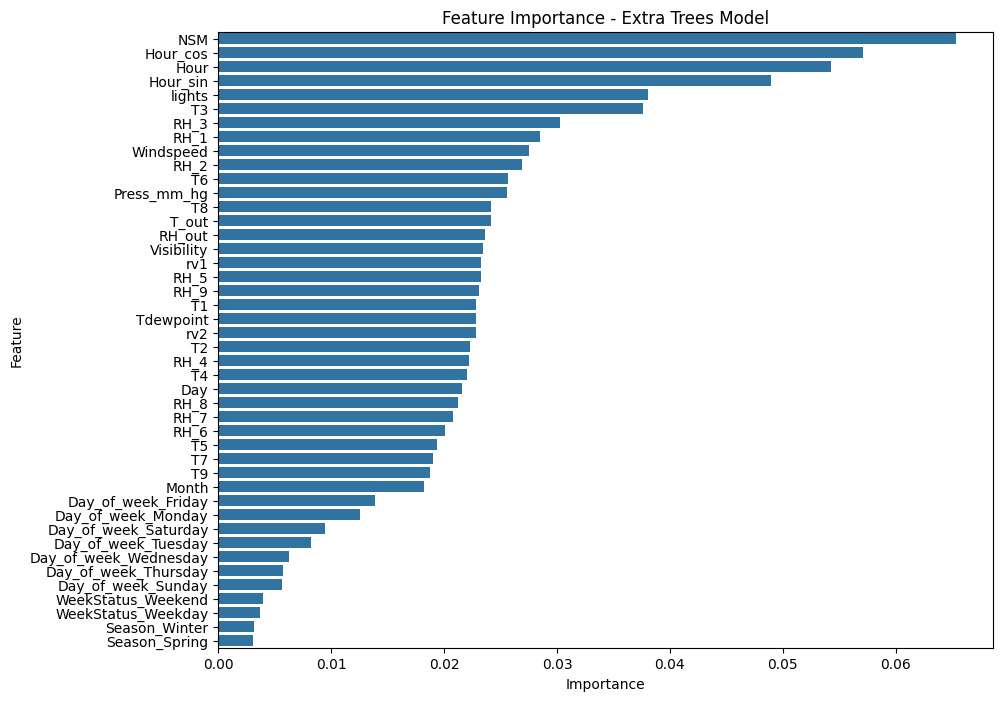

In [ ]:
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

# Feature Importance
feature_importances = best_et.feature_importances_
features = train[features].columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Extra Trees Model')
plt.savefig('image/Feature_Importance.png', dpi=300)
plt.show()

### Partial Dependence Plots

<Figure size 1200x1000 with 0 Axes>

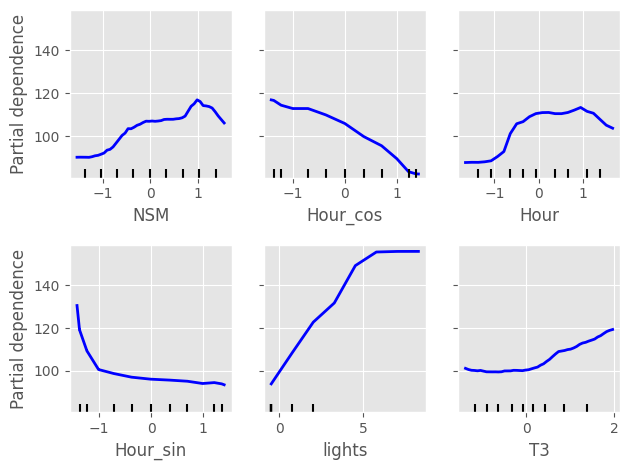

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Select the top 6 most important features for Partial Dependence Plots
top_features = importance_df['Feature'].iloc[:6].tolist()

# Set up the figure size and styling for better visualization
plt.figure(figsize=(12, 10))
plt.style.use('ggplot')  # Use ggplot style for a clean and professional look

# Plot Partial Dependence for the selected features using the trained Extra Trees model
display = PartialDependenceDisplay.from_estimator(
    best_et, 
    X_train, 
    features=top_features, 
    grid_resolution=50,
    n_cols=3,  # Arrange plots in 2 rows and 3 columns
    line_kw={"color": "blue", "lw": 2},  # Line color and width
)

# Customize the plots further if needed
for ax in display.axes_.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=14, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Add more space between rows

# Save the plot with high resolution for publication or report
plt.savefig('image/Partial_dependence.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### Experimenting Different subsets for RMSE scores

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

# Number of folds
n_splits = 10

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

# List to store fold results
cv_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit the model on training fold
    best_et.fit(X_tr, y_tr)
    
    # Predict on validation fold
    y_pred = best_et.predict(X_val)
    
    # Compute RMSE
    rmse = root_mean_squared_error(y_val, y_pred)
    
    # Store results
    cv_results.append({'Fold': fold, 'RMSE': rmse})

# Convert to DataFrame
cv_summary = pd.DataFrame(cv_results)

# Display summary table
cv_summary

Fold       RMSE
0     1  72.706075
1     2  62.802962
2     3  72.257486
3     4  62.524565
4     5  73.963581
5     6  68.907755
6     7  83.268774
7     8  67.352406
8     9  69.969005
9    10  67.310816

In [ ]:
# Plot the distribution of RMSE scores
plt.figure(figsize=(8, 6))
sns.histplot(cv_rmse_scores, kde=True)
plt.title('Distribution of Cross-Validation RMSE Scores')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.savefig('image/CV_RMSE_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

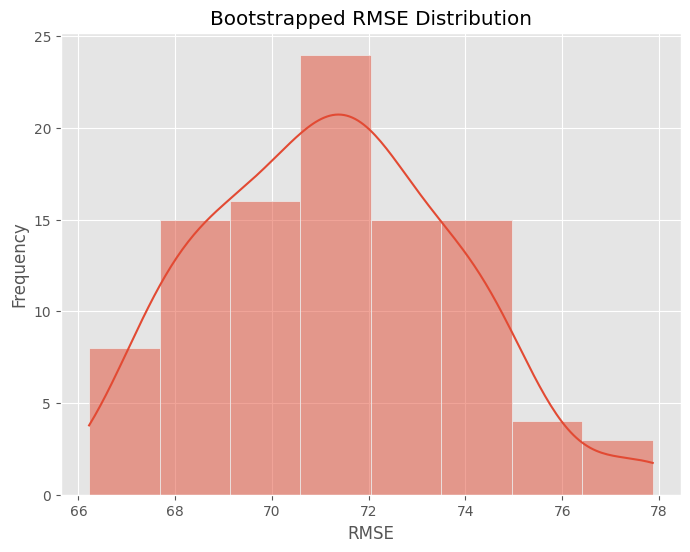

Mean Bootstrapped RMSE: 71.27272598716769
95% Confidence Interval: [67.26307199 76.52396008]


In [74]:
from sklearn.utils import resample

# Bootstrapping to evaluate model stability
n_iterations = 100
n_size = int(len(X_test) * 0.8)

bootstrapped_rmse = []
for i in range(n_iterations):
    # Bootstrap sample
    X_boot, y_boot = resample(X_test, y_test, n_samples=n_size)
    
    # Predict and evaluate RMSE
    y_boot_pred = best_et.predict(X_boot)
    rmse = np.sqrt(np.mean((y_boot - y_boot_pred) ** 2))
    bootstrapped_rmse.append(rmse)

# Plot distribution of bootstrapped RMSE scores
plt.figure(figsize=(8, 6))
sns.histplot(bootstrapped_rmse, kde=True)
plt.title('Bootstrapped RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.savefig('image/Bootstrapped_RMSE_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print mean and confidence intervals
print(f'Mean Bootstrapped RMSE: {np.mean(bootstrapped_rmse)}')
print(f'95% Confidence Interval: {np.percentile(bootstrapped_rmse, [2.5, 97.5])}')

### Residual Plots

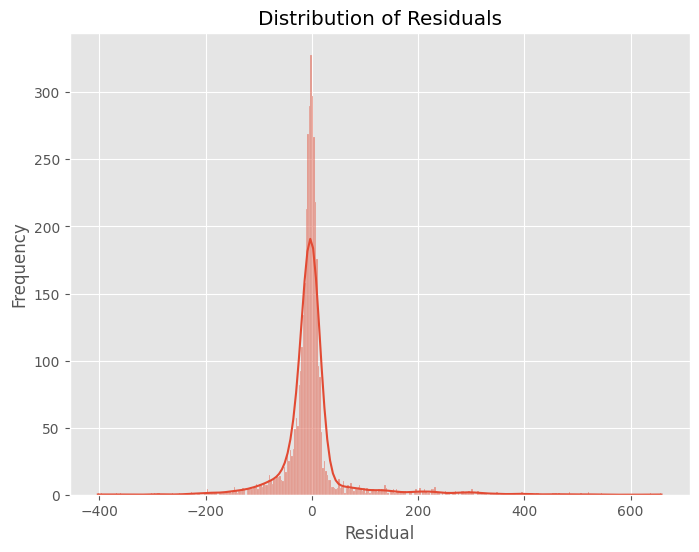

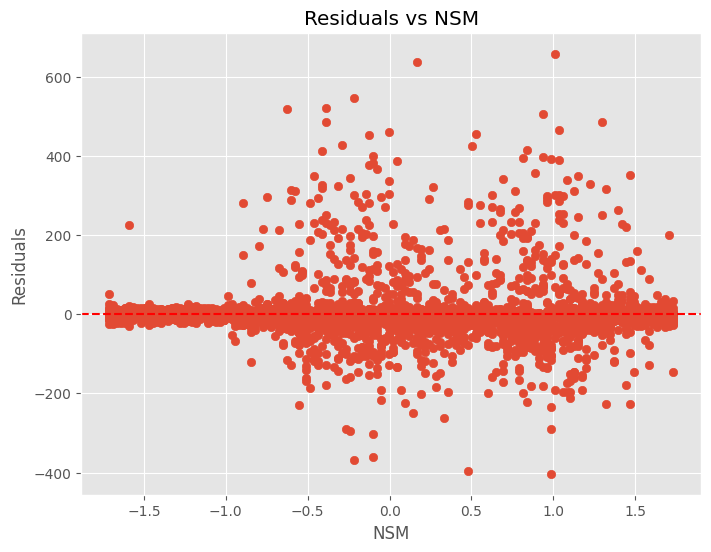

In [75]:
# Predict on the test set
y_pred = best_et.predict(X_test)

# Calculate the residuals (errors)
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.savefig('image/Residuals_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze errors in relation to one of the top features
top_feature = top_features[0]
plt.figure(figsize=(8, 6))
plt.scatter(X_test[top_feature], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuals vs {top_feature}')
plt.xlabel(f'{top_feature}')
plt.ylabel('Residuals')
plt.savefig(f'image/Residuals_vs_{top_feature}.png', dpi=300, bbox_inches='tight')
plt.show()

## Save model and Preprocessor

In [77]:
model_bundle = {
    "model": best_et,               # or your chosen model
    "scaler": scaler,
    "features": features,           # final list of columns AFTER dummies
    "categorical_cols": categorical_cols
}

In [78]:
import pickle

with open('et_model.bin', 'wb') as f_out:   # wb = write binary mode
    pickle.dump(model_bundle, f_out)

In [4]:
#!/usr/bin/env python
# coding: utf-8

import pickle
import warnings
warnings.filterwarnings('ignore')

# Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error

# -----------------------------
# Parameters
# -----------------------------
n_splits = 10
output_file = "extra_trees_energy_model.bin"


# -----------------------------
# Load and Prepare Data
# -----------------------------
energy_data = pd.read_csv("data/energydata_complete.csv")

energy_data['date'] = pd.to_datetime(energy_data['date'], format="%Y-%m-%d %H:%M:%S")

# -----------------------------
# Feature Engineering
# -----------------------------
def second_day(x):
    return x.hour * 3600 + x.minute * 60 + x.second

def weekend_weekday(x):
    return 'Weekend' if x.weekday() >= 5 else 'Weekday'

def get_season(month):
    if month in [3,4,5]: return 'Spring'
    if month in [6,7,8]: return 'Summer'
    if month in [9,10,11]: return 'Autumn'
    return 'Winter'

energy_data['NSM'] = energy_data['date'].apply(second_day)
energy_data['WeekStatus'] = energy_data['date'].apply(weekend_weekday)
energy_data['Day_of_week'] = energy_data['date'].dt.day_name()
energy_data['Hour'] = energy_data['date'].dt.hour
energy_data['Month'] = energy_data['date'].dt.month
energy_data['Day'] = energy_data['date'].dt.day
energy_data['Season'] = energy_data['Month'].apply(get_season)

# Cyclical encoding
energy_data['Hour_sin'] = np.sin(2 * np.pi * energy_data['Hour'] / 24)
energy_data['Hour_cos'] = np.cos(2 * np.pi * energy_data['Hour'] / 24)

# Convert categorical variables
cat_cols = ['Day_of_week', 'WeekStatus', 'Season']
for c in cat_cols:
    energy_data[c] = energy_data[c].astype('category')

data = energy_data.copy()


# -----------------------------
# Train–Val–Test Split
# -----------------------------
train_data, val_test_data = train_test_split(data, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

# One-hot encoding
categorical_cols = data.select_dtypes('category').columns.tolist()

train = pd.get_dummies(train_data, columns=categorical_cols)
val   = pd.get_dummies(val_data, columns=categorical_cols)
test  = pd.get_dummies(test_data, columns=categorical_cols)

# Convert booleans
for df in (train, val, test):
    df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

# Align columns
train, val = train.align(val, join="left", axis=1, fill_value=0)
train, test = train.align(test, join="left", axis=1, fill_value=0)

# -----------------------------
# Prepare Features
# -----------------------------
target = 'Appliances'
features = [col for col in train.columns if col not in [target, 'date']]

In [5]:

train_data.head(1).to_dict(orient='records')[0]

{'date': Timestamp('2016-04-24 09:10:00'),
 'Appliances': 100,
 'lights': 10,
 'T1': 21.5,
 'RH_1': 36.6633333333333,
 'T2': 18.73,
 'RH_2': 39.223333333333294,
 'T3': 22.9266666666667,
 'RH_3': 34.4,
 'T4': 21.7,
 'RH_4': 34.3214285714286,
 'T5': 20.9266666666667,
 'RH_5': 65.8933333333333,
 'T6': 5.29666666666667,
 'RH_6': 53.55666666666671,
 'T7': 21.40375,
 'RH_7': 32.53375,
 'T8': 22.79,
 'RH_8': 38.7,
 'T9': 20.463333333333296,
 'RH_9': 36.76,
 'T_out': 4.15,
 'Press_mm_hg': 758.0666666666668,
 'RH_out': 87.1666666666667,
 'Windspeed': 4.0,
 'Visibility': 26.5,
 'Tdewpoint': 2.2,
 'rv1': 16.421150916721672,
 'rv2': 16.421150916721672,
 'NSM': 33000,
 'WeekStatus': 'Weekend',
 'Day_of_week': 'Sunday',
 'Hour': 9,
 'Month': 4,
 'Day': 24,
 'Season': 'Spring',
 'Hour_sin': 0.7071067811865476,
 'Hour_cos': -0.7071067811865475}

In [ ]:

scaler = StandardScaler()

X_train = scaler.fit_transform(train[features])
y_train = train[target]

X_val = scaler.transform(val[features])
y_val = val[target]

X_test = scaler.transform(test[features])
y_test = test[target]


# -----------------------------
# ExtraTrees Regressor
# -----------------------------
print("Training ExtraTreesRegressor...")
et = ExtraTreesRegressor(random_state=1)
et.fit(X_train, y_train)

# -----------------------------
# Cross-validation
# -----------------------------
print("Performing Cross-Validation...")
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_vl = X_train[train_idx], X_train[val_idx]
    y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = ExtraTreesRegressor(random_state=1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)

    rmse = root_mean_squared_error(y_vl, y_pred)
    cv_results.append({'Fold': fold, 'RMSE': rmse})

cv_summary = pd.DataFrame(cv_results)
print("\nCross-Validation Summary:\n")
print(cv_summary)
print("\nMean RMSE:", cv_summary['RMSE'].mean())
print("Std RMSE:", cv_summary['RMSE'].std())


# -----------------------------
# Evaluate Model
# -----------------------------
def evaluate(model):
    preds = model.predict(X_test)
    return {
        "RMSE": root_mean_squared_error(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "MAPE": mean_absolute_percentage_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

final_metrics = evaluate(et)
print("\nFinal Test Metrics:\n", final_metrics)


# -----------------------------
# Save Model + Scaler
# -----------------------------
with open(output_file, "wb") as f_out:
    pickle.dump((et, scaler, features), f_out)

print(f"\nModel saved as: {output_file}")

In [ ]:
X_train = scaler.fit_transform(train[features])
y_train = train[target]

X_val = scaler.transform(val[features])
y_val = val[target]

X_test = scaler.transform(test[features])
y_test = test[target]


# -----------------------------
# ExtraTrees Regressor
# -----------------------------
print("Training ExtraTreesRegressor...")
et = ExtraTreesRegressor(random_state=1)
et.fit(X_train, y_train)

# -----------------------------
# Cross-validation
# -----------------------------
print("Performing Cross-Validation...")
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_vl = X_train[train_idx], X_train[val_idx]
    y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = ExtraTreesRegressor(random_state=1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)

    rmse = root_mean_squared_error(y_vl, y_pred)
    cv_results.append({'Fold': fold, 'RMSE': rmse})

cv_summary = pd.DataFrame(cv_results)
print("\nCross-Validation Summary:\n")
print(cv_summary)
print("\nMean RMSE:", cv_summary['RMSE'].mean())
print("Std RMSE:", cv_summary['RMSE'].std())


# -----------------------------
# Evaluate Model
# -----------------------------
def evaluate(model):
    preds = model.predict(X_test)
    return {
        "RMSE": root_mean_squared_error(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "MAPE": mean_absolute_percentage_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

final_metrics = evaluate(et)
print("\nFinal Test Metrics:\n", final_metrics)

Training ExtraTreesRegressor...
Performing Cross-Validation...

Cross-Validation Summary:

   Fold       RMSE
0     1  71.812204
1     2  63.574082
2     3  71.250133
3     4  63.092454
4     5  75.324472
5     6  68.420746
6     7  83.330082
7     8  67.477524
8     9  69.377801
9    10  66.710290

Mean RMSE: 70.03697892913165
Std RMSE: 5.962355977342932

Final Test Metrics:
 {'RMSE': 70.76452240432516, 'MAE': 32.38051684823917, 'MAPE': 0.2988592307311988, 'R2': 0.5655476683970888}

Model saved as: extra_trees_energy_model.bin


In [6]:
# -----------------------------
# Save Model + Scaler
# -----------------------------
with open(output_file, "wb") as f_out:
    pickle.dump((et, scaler, features), f_out)

print(f"\nModel saved as: {output_file}")


Model saved as: extra_trees_energy_model.bin


In [ ]:
print(f"\nModel saved as: {output_file}")
